In [27]:
# https://github.com/42io/dataset/tree/master/google_speech_commands#numpy-example
DATASET_FILE = '1gmnWx2we0I-RNiWSvIRN7RzUrJrSp_uQ' # 0-9up.npz

In [28]:
!test -f "$DATASET_FILE" || sudo pip install gdown

In [29]:
!test -f "$DATASET_FILE" || gdown --id "$DATASET_FILE" -O "$DATASET_FILE"

In [30]:
import subprocess
assert(b'cb126d837b86b1f6baf5c8268804877a' == subprocess.run(['md5sum', DATASET_FILE], stdout=subprocess.PIPE).stdout.split()[0])

In [31]:
import numpy as np
from tensorflow import keras as keras

In [32]:
dset = np.load(DATASET_FILE)
print(dset['x_train'].shape)

(1095480, 637)


In [33]:
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=(637,)))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(12, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=25,
        restore_best_weights=True)

history = model.fit(dset['x_train'],
                    keras.utils.to_categorical(dset['y_train']),
                    validation_data=(dset['x_valid'], keras.utils.to_categorical(dset['y_valid'])),
                    callbacks=[early_stopping],
                    verbose=2,
                    epochs=150)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                40832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 12)                1548      
Total params: 50,700
Trainable params: 50,700
Non-trainable params: 0
_________________________________________________________________
Train on 1095480 samples, validate on 3368 samples
Epoch 1/150
1095480/1095480 - 75s - loss: 0.8066 - accuracy: 0.74

In [34]:
results = model.evaluate(dset['x_train'], keras.utils.to_categorical(dset['y_train']), verbose=0)
print('train loss, train acc:', results)

results = model.evaluate(dset['x_test'], keras.utils.to_categorical(dset['y_test']), verbose=0)
print('test loss, test acc:', results)

results = model.evaluate(dset['x_valid'], keras.utils.to_categorical(dset['y_valid']), verbose=0)
print('valid loss, valid acc:', results)

train loss, train acc: [0.3647801303122064, 0.88563824]
test loss, test acc: [0.4835639501929978, 0.8489266]
valid loss, valid acc: [0.431150280009964, 0.8637173]


In [35]:
assert(len(dset['x_test']) + len(dset['x_valid']) == 7141)
pred = model.predict_classes(dset['x_test'])
print(np.sum(pred != dset['y_test']), len(pred))
pred = model.predict_classes(dset['x_valid'])
print(np.sum(pred != dset['y_valid']), len(pred))

570 3773
459 3368


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


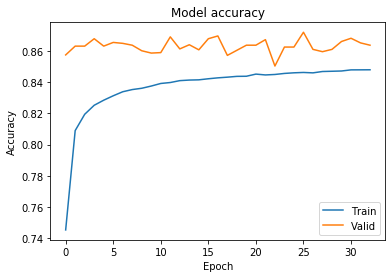

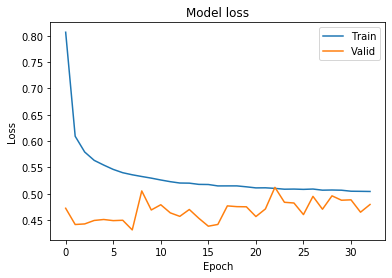

In [36]:
print(history.history.keys())

%matplotlib inline

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [37]:
import tensorflow as tf
print(tf.__version__)

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

2.1.0


In [38]:
!mkdir -p './models'
with open("./models/mlp.tflite", "wb") as f:
  f.write(tflite_model)
!md5sum ./models/mlp.tflite

de9427f39dfe73b1b02b215eee8c7506  ./models/mlp.tflite
